In [1]:
import numpy as np
import cv2
import random
from tqdm import tqdm
import os

In [2]:
TRAIN_DIR = './train/'
TEST_DIR = './test/'
IMG_SIZE = 40
LR = 0.001

In [3]:
MODEL_NAME = 'dogs_cats_{}_{}.model'.format(LR, 'convNet6')

In [4]:
def label_img(path):
    if path.split('.')[-3] == 'cat':
        return [1,0]
    return [0,1]
label_img('cat.001.png')

[1, 0]

In [5]:
def createTrainData():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        
        train_data.append([np.array(img),np.array(label)])
        
    random.shuffle(train_data)
    np.save('train.npy',train_data)
    return True

In [6]:
def processTestData():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        
        test_data.append([np.array(img), img_num])
        
    np.save('test.npy', test_data)
    return True

In [7]:
#createTrainData()
train_data = np.load('train.npy')
#processTestData()

In [8]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convNet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convNet = conv_2d(convNet, 32, 2, activation='relu')
convNet = max_pool_2d(convNet, 2)

convNet = conv_2d(convNet, 64, 2, activation='relu')
convNet = max_pool_2d(convNet, 2)

convNet = conv_2d(convNet, 32, 2, activation='relu')
convNet = max_pool_2d(convNet, 2)

convNet = conv_2d(convNet, 64, 2, activation='relu')
convNet = max_pool_2d(convNet, 2)

convNet = conv_2d(convNet, 32, 2, activation='relu')
convNet = max_pool_2d(convNet, 2)

convNet = conv_2d(convNet, 64, 2, activation='relu')
convNet = max_pool_2d(convNet, 2)

convNet = fully_connected(convNet, 1024, activation='relu')
convNet = dropout(convNet, 0.8)

convNet = fully_connected(convNet, 2, activation='softmax')
convNet = regression(convNet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='yhat')

model = tflearn.DNN(convNet, tensorboard_dir='./log/')

In [13]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("Model Loaded")    

INFO:tensorflow:Restoring parameters from /home/deep/dogs_vs_cats/dogs_cats_0.001_convNet6.model
Model Loaded


In [10]:
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [15]:
model.fit(X,Y, n_epoch=3, validation_set=(test_x, test_y), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3446  | total loss: 0.38745 | time: 76.175s
| Adam | epoch: 009 | loss: 0.38745 - acc: 0.8216 -- iter: 24448/24500
Training Step: 3447  | total loss: 0.38512 | time: 77.321s
| Adam | epoch: 009 | loss: 0.38512 - acc: 0.8254 | val_loss: 0.48273 - val_acc: 0.7920 -- iter: 24500/24500
--


In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/deep/dogs_vs_cats/dogs_cats_0.001_convNet6.model is not in all_model_checkpoint_paths. Manually adding it.


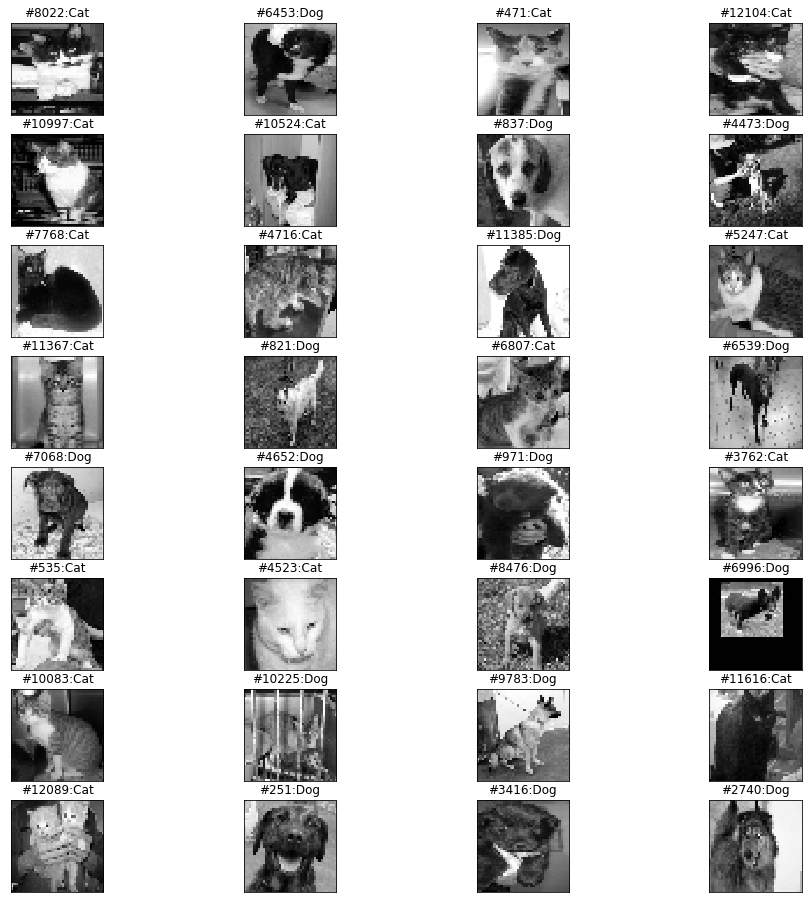

In [20]:
import matplotlib.pyplot as plt

test_data = np.load('test.npy')

fig = plt.figure(figsize=(16, 16))

for num, data in enumerate(test_data[:32]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(8, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        lbl = 'Dog'
    else:
        lbl = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title("#{}:{}".format(img_num,lbl))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show() 
            